In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Image

%pylab inline

pylab.rcParams['figure.figsize'] = (10, 6)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**1. Install `TISEAN`**

**2. The standard first step in the analysis of a scalar time series from a nonlinear dynamical system is to choose the delay $\tau$. Use `TISEAN`'s `mutual` tool to construct a plot of mutual information vesus $\tau$ for `data2.first250sec`. We're looking for the first minumum.**

First we run `TISEAN` with default parameters.

In [35]:
%%bash --out p2_mutual_string --err error

mutual ps8data/data2.first250sec

Using iPython bash magic we export the output to `stdout` (there are only 20 rows) and import into a `pandas` `DataFrame`.

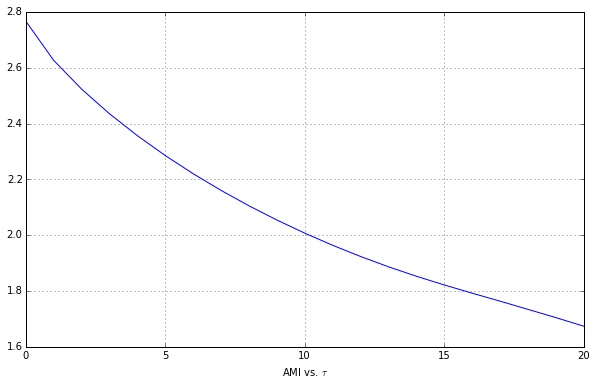

In [36]:
p2_mutual = np.array([r.split(' ') for r in
                p2_mutual_string.split('\n')][1:-1],
                dtype=np.float64)

p2d = pd.DataFrame(p2_mutual, columns=['Tau', 'AMI'])

p2d.plot(x='Tau', y='AMI', label=r'AMI vs. $\tau$', legend=False)
plt.show()

We don't see a minimum, so we're going to slowly increase the max time delay parameter until we see that minimum.

In [37]:
%%bash --out p2_mutual_string --err error

mutual -D 200 ps8data/data2.first250sec

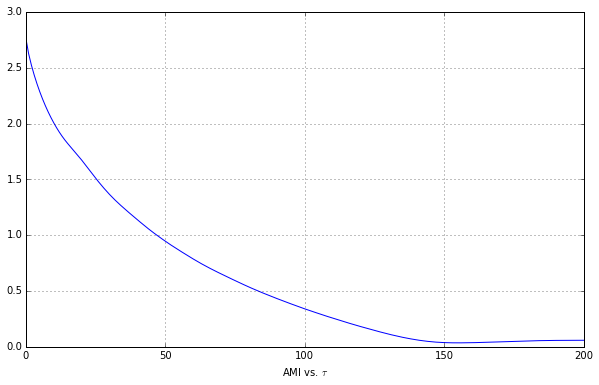

In [38]:
p2_mutual = np.array([r.split(' ') for r in
                p2_mutual_string.split('\n')][1:-1],
                dtype=np.float64)

p2d = pd.DataFrame(p2_mutual, columns=['Tau', 'AMI'])

p2d.plot(x='Tau', y='AMI', label=r'AMI vs. $\tau$', legend=False)
plt.show()

This minimum is now apparent, so let's figure out the $\tau$ value at which it occurs.

In [39]:
p2min = p2d.idxmin()
p2min

Tau      0
AMI    155
dtype: int64

We need the data time interval to figure out this value in seconds.

In [40]:
p2_file_data = pd.read_csv('ps8data/data2.first250sec',
                            names=['angle', '', '', 'time'],
                            sep=' ')[['angle', 'time']]
interval = p2_file_data['time'][1] - p2_file_data['time'][0]
interval

0.002

Yielding a $\tau$ value of

In [41]:
p2min['AMI'] * interval

0.31

**3. The standard second step in nonlinear time-series analysis is to choose the embedding dimension $m$. Use `TISEAN`'s `false_nearest` tool to construct a plot of the percent of false-near neighbors versus $m$ for the same dataset. Use an $m$ range of $[1, 10]$, using $\tau$ from before, and leave the other parameters at their default values. Plot the results.**

The first step is to use `TISEAN`.

In [42]:
%%bash --out p3_false_nearest_string --err error

false_nearest -d 155 -m 1 -M 1,10 ps8data/data2.first250sec

In [43]:
p3d = pd.DataFrame(np.array([r.split(' ') for r in
                   p3_false_nearest_string.split('\n')[:-1]],
                   dtype=np.float64),
                   columns=['Dimension', 'Frac. FNN',
                          'Avg. Neighborhood Size',
                          'Avg. Neighborhood^2 Size'])
p3d

Dimension  Frac. FNN  Avg. Neighborhood Size  Avg. Neighborhood^2 Size
0          1   0.893131                0.001500                  0.001500
1          2   0.659106                0.001569                  0.003657
2          3   0.475366                0.001912                  0.004873
3          4   0.335245                0.002482                  0.005668
4          5   0.232490                0.003070                  0.006467
5          6   0.163109                0.003606                  0.007233
6          7   0.119633                0.004089                  0.007943
7          8   0.090941                0.004534                  0.008621
8          9   0.070794                0.004944                  0.009264
9         10   0.056035                0.005338                  0.009888

Now we can plot this.

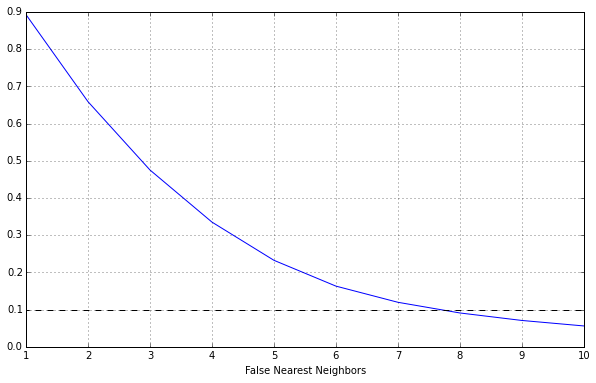

In [44]:
p3d.plot(x='Dimension', y='Frac. FNN',
         label='False Nearest Neighbors', legend=False)
plt.plot(np.arange(0, 11), 0.1 * np.ones(11), 'k--')
plt.show()

Looking at the data we see that $m=8$ is the optimal value.

**4. Use `TISEAN`'s `delay` tool to embed the same dataset using the found values of $\tau$ and $m$. Compare to the plot from PS8.**

First with `TISEAN`.

In [45]:
%%bash --out p4_delay_string --err error

delay -m 8 -d 155 ps8data/data2.first250sec

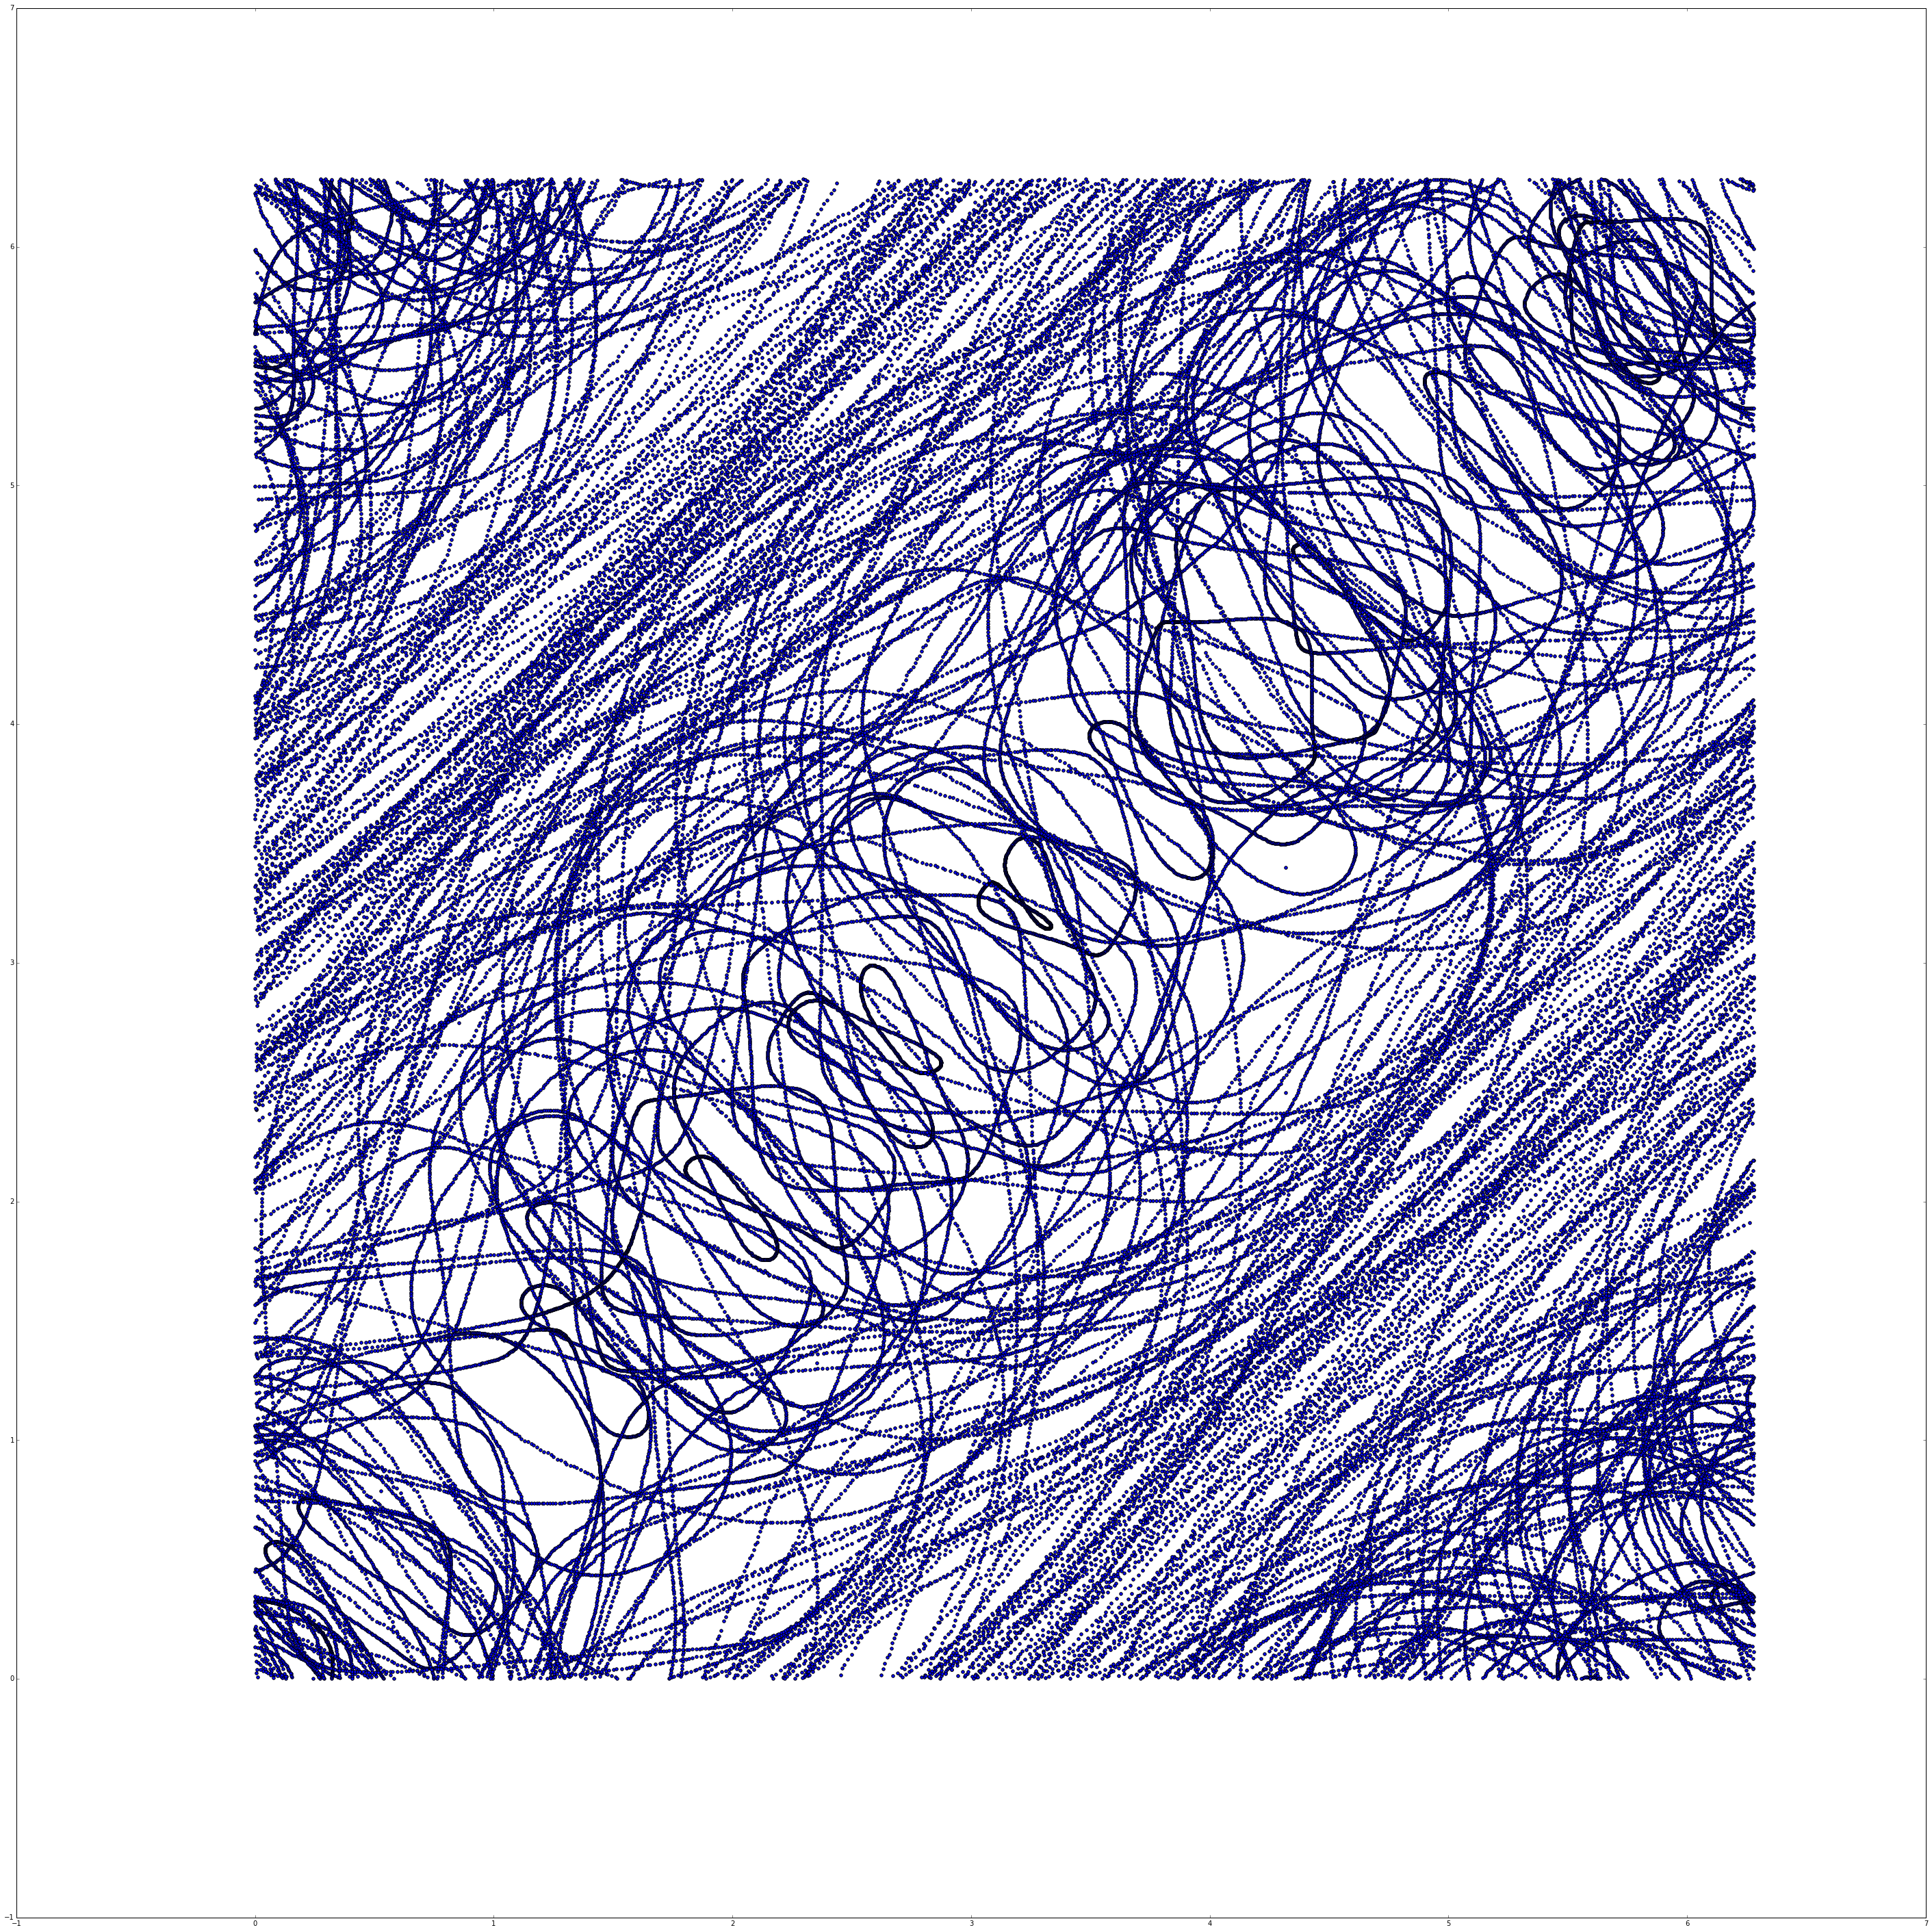

In [46]:
p4d = pd.DataFrame(np.array([r.split(' ')[:-1] for r in
                   p4_delay_string.split('\n')[:-1]],
                   dtype=np.float64))
plt.figure(figsize=(50, 50))
plt.scatter(p4d[0], p4d[1])
plt.show()

Now we can compare to our image from Problem Set 8.

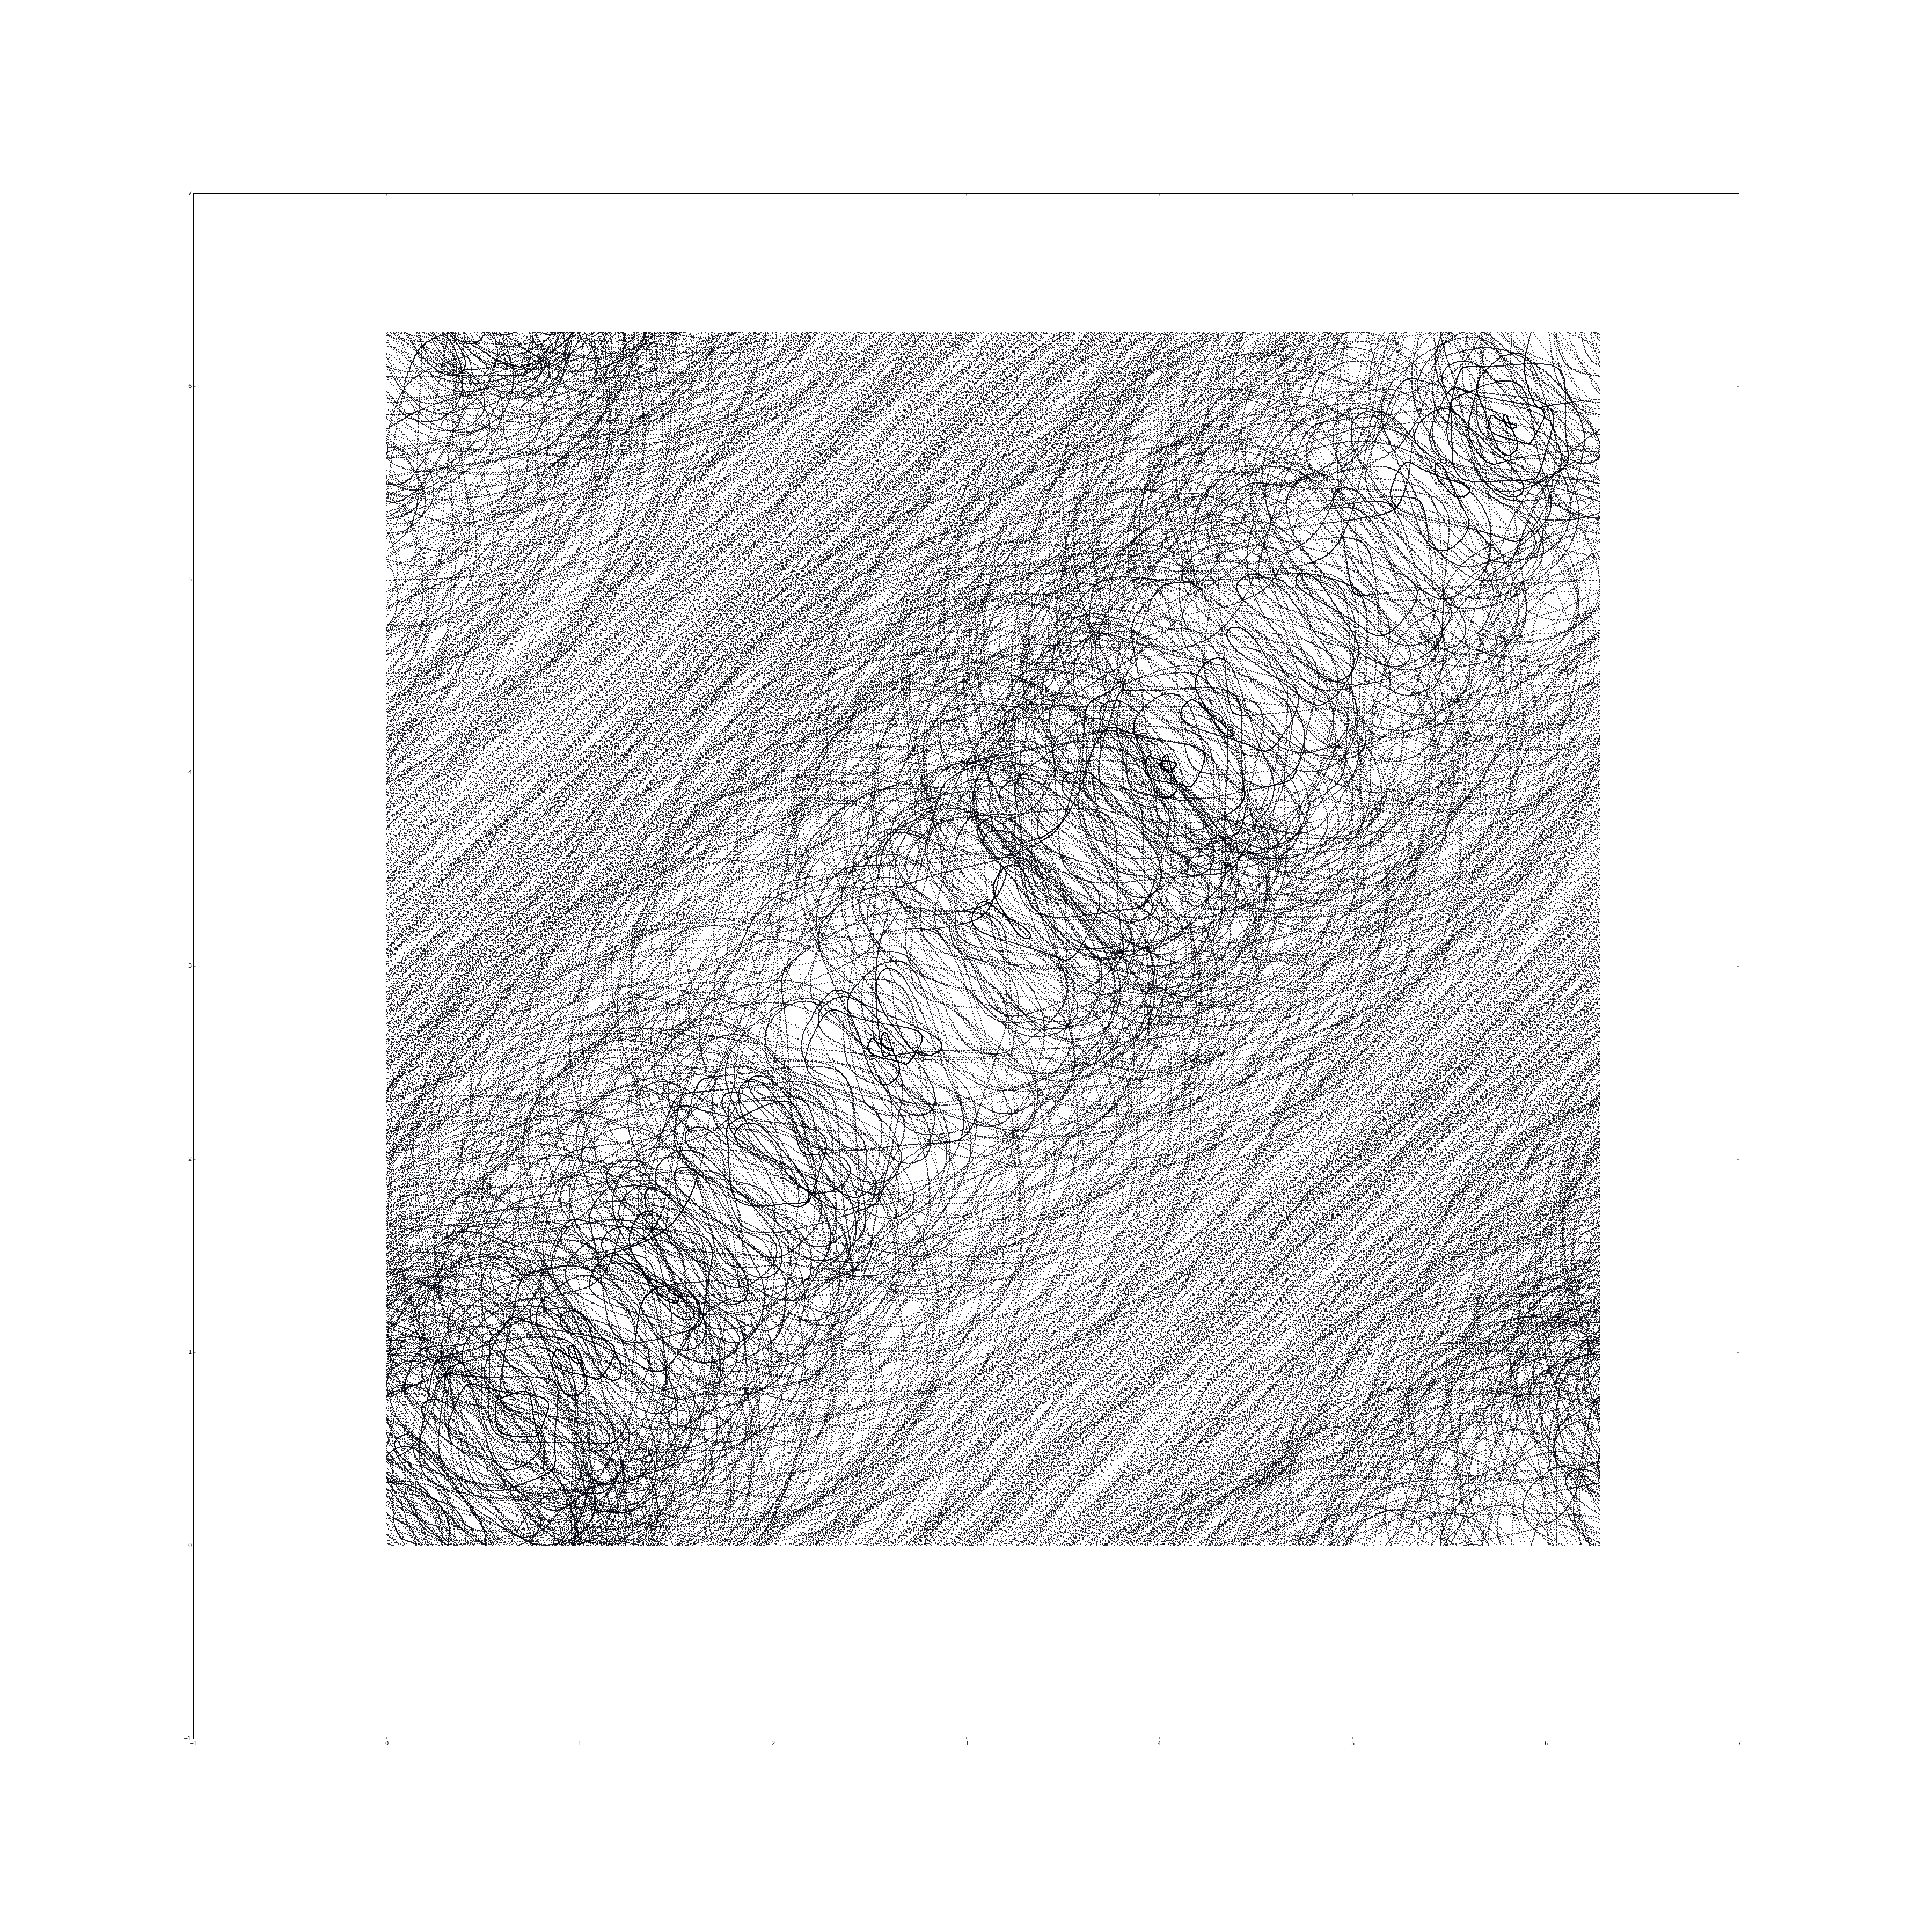

In [47]:
Image(filename='../problemset8/out.png') 

We'll note that in problem set 8 we used $\tau=0.15$, while `TISEAN` gave us optimal $\tau=0.31$. We also note that in problem set 8 we used 7 embedding dimensions, while here `TISEAN` gave us $m=8$. These two changes result in a final embedding that has much less "noise", with a much more apparent structure.

**5a. Use `TISEAN`'s `lyap_k` tool to estimate the largest Lyapunov exponent of the `data2` data set.**

In [116]:
%%bash --out p5a_output_string --err error

lyap_k -m 8 -M 8 -d 155 -R 1 -r 0.5 ps8data/data2 -o data2.lyap

`lyap_k` automatically saves the results to file, there's no way to just keep it in memory, so we have to read in the resulting `csv`.

In [117]:
p5ad = (pd.read_csv('data2.lyap', sep=' ',
                    names=['Iteration', 'log(stretch)',
                           'Points Number', '', ''])
                    [['Iteration',
                      'log(stretch)',
                      'Points Number']][1:])

In order to get each individual line we need to group by the number of points.

In [118]:
p5ag = p5ad.groupby('Points Number', axis=0)
groups = dict(list(p5ag))
groups.keys()

dict_keys([498730.0, 498782.0, 498717.0, 498774.0, 498757.0])

And now we can plot each line.

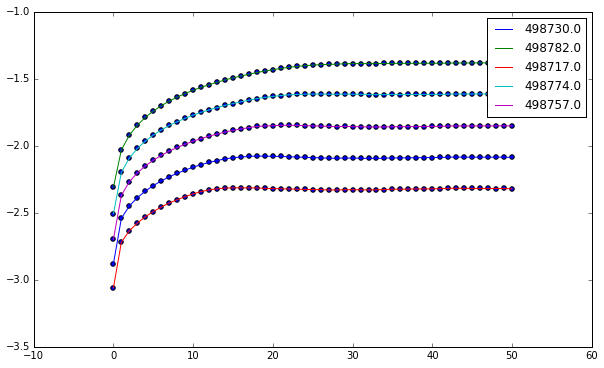

In [120]:
plt.figure()
for key in groups:
    x = np.array(groups[key]['Iteration'].values,
                                    dtype=np.float64)
    y = np.array(groups[key]['log(stretch)'].values,
                                    dtype=np.float64)
    plt.scatter(x, y)
    plt.plot(x, y, label=key)
plt.legend()
plt.show()

We can do simple linear regression to determine the slope of our line, which corresponds to the highest Lyapunov exponent.

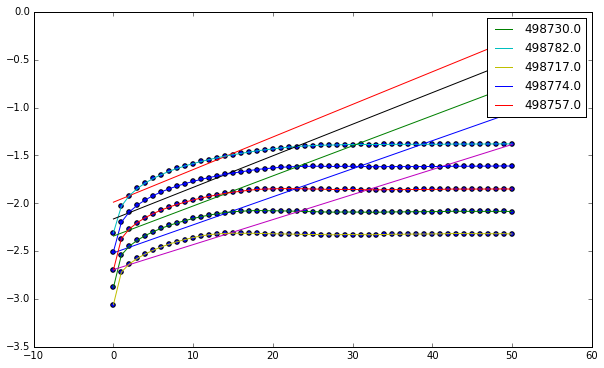

In [122]:
plt.figure()
lyap = []
for key in groups:
    x = np.array(groups[key]['Iteration'].values,
                                    dtype=np.float64)
    y = np.array(groups[key]['log(stretch)'].values,
                                    dtype=np.float64)
    coeff = np.polyfit(x[:20], y[:20], 1)
    lyap.append(coeff[0])
    line = lambda x: coeff[0] * x + coeff[1]
    plt.plot(x, line(x))
    plt.scatter(x, y)
    plt.plot(x, y, label=key)
plt.legend()
plt.show()

Now we can calculate, taking care to multiply by the interval in order to get the units in terms of seconds.

In [164]:
[interval * val for val in lyap]

[5.8626472180451108e-05,
 6.815021503759399e-05,
 5.2334255639097616e-05,
 6.6019834586466281e-05,
 6.2911362406014887e-05]

Using these values we see that our $\lambda \approx 5.5 \times 10^{-5}$.

**(b) Now try varying $m$. What do you observe in your results? What does that suggest about your $m$ value and/or the data?**

First we try with $m = 20$, to see if more dimensions drastically change our results.

In [128]:
%%bash --out p5a_output_string --err error

lyap_k -r 0.5 -R 1 -m 20 -M 20 -d 155 ps8data/data2 -o data2_m20.lyap

In [134]:
def lyap_plot(name):
    """
    Above steps condensed into function
    """
    data = (pd.read_csv(name, sep=' ',
                        names=['Iteration', 'log(stretch)',
                               'Points Number', '', ''])
                        [['Iteration',
                          'log(stretch)',
                          'Points Number']][1:])

    data_g = data.groupby('Points Number', axis=0)
    groups = dict(list(data_g))
    groups.keys()

    lyap = []
    plt.figure()
    for key in groups:
        x = np.array(groups[key]['Iteration'].values,
                                        dtype=np.float64)
        y = np.array(groups[key]['log(stretch)'].values,
                                        dtype=np.float64)
        coeff = np.polyfit(x[:20], y[:20], 1)
        line = lambda x: coeff[0] * x + coeff[1]
        lyap.append(coeff[0])
        plt.plot(x, line(x))
        plt.scatter(x, y)
        plt.plot(x, y, label=key)
    plt.legend()
    plt.show()
    
    return lyap

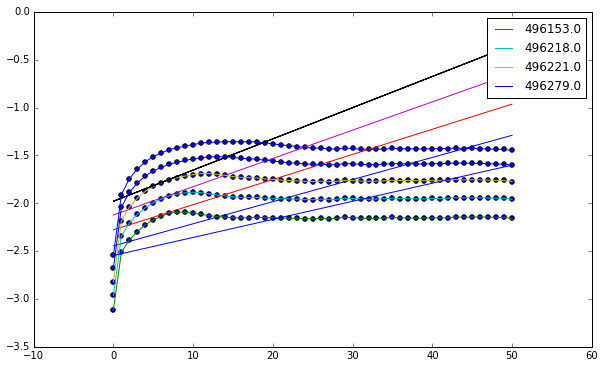

[4.6226607518796982e-05,
 5.2542124812030048e-05,
 5.9114353383458675e-05,
 6.5211945864661832e-05]

In [163]:
[interval * val for val in lyap_plot('data2_m20.lyap')]

Using these values we see that our $\lambda \approx 5.5 \times 10^{-5}$.

We see that the values here are essentially the same as before, indicating that our estimate for $\lambda$ is accurate. This essentially means that our estimate for $m$ was a good one and that the data itself is mostly accurate, as noise isn't much of an isse.

**6 (a) A good way to test a tool is to feed it a fake data set, one where we know the answer. Use RK4 to generate a $30,000$ point trajectory starting from some point near the $a = 16$, $r = 45$, $b = 4$ Lorenz attractor using a step size of $0.001$. Throw out the $y$ and $z$ coordinates and embed the $x$ coordinate. Use `mutual` to estimate $\tau$, but don't repeat the `false_nearest` analysis to choose $m$, just use $m = 7$.**

We need to get our RK4 solver in here.

In [59]:
import ps5lib

The Lorenz attractor is defined as

$$
\vec{F}\left( \vec{x}, a, r, b \right) =
\left[
\begin{array}{c}
\dot{x}\\
\dot{y}\\
\dot{z}\\
\end{array}
\right]
=
\left[
\begin{array}{c}
a(y - x)\\
rx - y - xz\\
xy - bz\\
\end{array}
\right]
$$

In [196]:
a = 16
r = 45
b = 4
initial_state = np.array([28, 10, 8/3])

lorenz = lambda t, y: np.array([a * (y[1] - y[0]),
                                r * y[0] - y[1] - y[0] * y[2],
                                y[0] * y[1] - b * y[2]])

We can now plug our system into our solver.

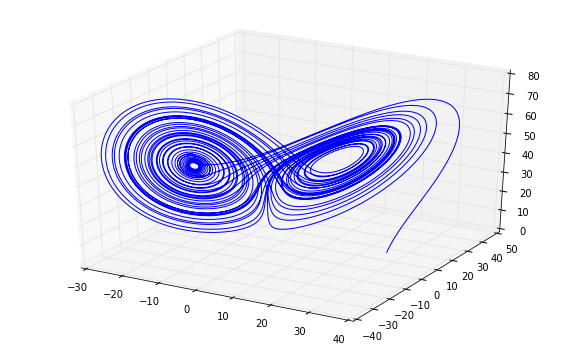

In [208]:
data = ps5lib.mrk4(lorenz, 0, initial_state,
                    0.001, 30000, writecsv='p6_lorenz.csv')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(data[:, 0], data[:, 1], data[:, 2])
plt.show()

Now let's use `mutual` to estimate our $\tau$.

In [209]:
output = !mutual -D 200 p6_lorenz.csv
p6d_raw = np.array([row.split(' ') for row in output[10:]],
                   dtype=np.float64)

We can plot our results.

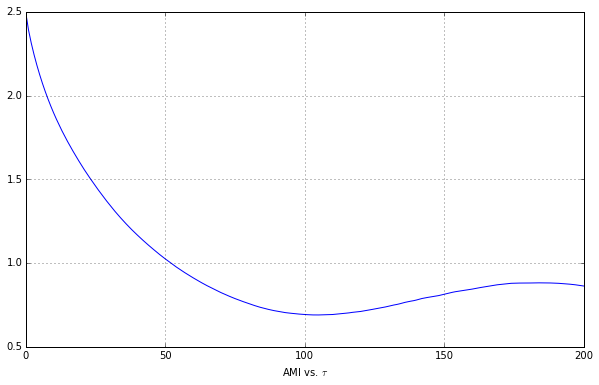

In [210]:
p6d = pd.DataFrame(p6d_raw, columns=['Tau', 'AMI'])

p6d.plot(x='Tau', y='AMI', label=r'AMI vs. $\tau$', legend=False)
plt.show()

In [211]:
p6d.idxmin()

Tau      0
AMI    104
dtype: int64

Yielding our first min value to be $\tau = 0.105$, or in terms of intervals, $\tau = 105$.

**What does `lyap_k` tell you about $\lambda$? Turn in this plot. Does that value make sense?**

In [212]:
%%bash --out output --err error

lyap_k -R 0.5 -r 0.1 -m 7 -M 7 -d 104 p6_lorenz.csv -o p6_lorenz.lyap

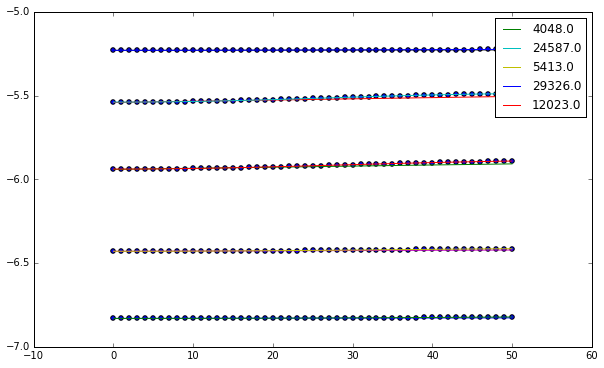

[6.8879699247983426e-08,
 7.2126691729333411e-07,
 1.5672180451129786e-07,
 5.9252631578879269e-08,
 6.577045112781558e-07]

In [239]:
[0.001 * val for val in lyap_plot('p6_lorenz.lyap')]

This tells us that a good approximation is $\lambda \approx 7 \times 10^{-7}$. This generally makes sense as the attractor stays in a finite area.

**(b) Run the PS7 code from the same initial condition and compute the eigenvalues of the resulting variational matrix and use them to calculate the exponents:**

$$
\lambda_i = \lim_{t \to \infty} \frac{1}{t} \ln \lvert m_i (t) \rvert
$$

**where $m_i(t)$ are the eigenvalues of the variational matrix $\{\delta_{ij}\}$. Compare these results to your answers in part (a).**

In [233]:
def gen_lorenz(a, r, b):
    lorenz = lambda t, y: np.array([a * (y[1] - y[0]),
                                    r * y[0] - y[1] - y[0] * y[2],
                                    y[0] * y[1] - b * y[2],
                                    -a * y[3] + a * y[6],
                                    -a * y[4] + a * y[7],
                                    -a * y[5] + a * y[8],
                                    (r - y[2]) * y[3] - y[6] - y[0] * y[9],
                                    (r - y[2]) * y[4] - y[7] - y[0] * y[10],
                                    (r - y[2]) * y[5] - y[8] - y[0] * y[11],
                                    y[1] * y[3] + y[0] * y[6] - b * y[9],
                                    y[1] * y[4] + y[0] * y[7] - b * y[10],
                                    y[1] * y[5] + y[0] * y[8] - b * y[11]])
    return lorenz

Now we can create a Lorenz system with the correct parameters and solve.

In [234]:
lorenz = gen_lorenz(16, 45, 4)
initial_state = np.array([0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, 1],
                         dtype=np.float64)
data = ps5lib.mrk4(lorenz, 0, initial_state, 0.001, 30000)

We can extract the final variational matrix from this result.

In [235]:
variation = np.array([data[-1, 3:6], data[-1, 6:9], data[-1, 9:12]])
variation

array([[ -4.63477474e+14,  -3.51754723e+14,  -8.82985607e+14],
       [ -7.10797071e+14,  -5.39457127e+14,  -1.35416200e+15],
       [ -6.09234089e+13,  -4.62376231e+13,  -1.16067115e+14]])

Finding the eigenvalues is straightforward.

In [236]:
eigenvalues = np.linalg.eig(variation)[0]
eigenvalues

array([ -1.11900172e+15,   7.59213360e-02,   1.05748944e+01])

Finally we can solve the limit.

In [240]:
np.log(np.abs(eigenvalues)) / 1e90

array([  3.46512134e-89,  -2.57805753e-90,   2.35848274e-90])

This limit will go to zero, which doesn't quite mesh with my above answer. Assuming that machine error is the cause, we'll assume that Kantz' algorithm is accurate in this case.